In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
from helpers import *


In [142]:
DATA_FOLDER = "../Data/"
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [187]:
actors = actors_load.copy()
movies = movies_load.copy()

In [188]:
actors = actors.query("numMovies >=10")
len(actors)

9437

In [189]:
actors_exp = explode_on_movies(actors)

In [190]:
actors_movies = actors_exp.merge(movies[["fbID","genres","releaseMonth","releaseYear"]], how="left", on="fbID")
actors_movies_sort = actors_movies.sort_values(by=["fbActorID", "ageAtMovieRelease","releaseYear","releaseMonth"])
actors_min_movies = actors_movies_sort.query("numMovies >=20")
actors_min_movies = actors_min_movies[
    ~(actors_min_movies.ageAtMovieRelease.isna() & actors_min_movies.releaseYear.isna())
]
actors_min_movies = actors_min_movies[~actors_min_movies.genres.isna()]
actors_min_movies["genresLen"] = actors_min_movies.genres.apply(lambda x:len(x))
actors_min_movies["LastMovie"] = np.array([*(actors_min_movies.fbActorID[1:].values != actors_min_movies.fbActorID.values[:-1]),True]) 
actors_min_movies["count_NHHI"] = np.array([*(actors_min_movies.fbActorID[5:].values == actors_min_movies.fbActorID.values[:-5]),True, True, True,True,True])
genreslist = actors_min_movies.genres.explode().value_counts().index

In [191]:
exploded_actors_genres = actors_min_movies.explode("genres")

In [192]:
# Create dummy variables for genres using one-hot encoding
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID","LastMovie"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

genre_dummies[genreslist] = (1 * genre_dummies[genreslist]).div(
    genre_dummies["genresLen"], axis=0
)

# Group by fbActorID and aggregate data, summing up occurrences of each genre
actor_genre_counts = (
    genre_dummies
    .groupby(["fbActorID", "fbID", "LastMovie"], sort=False)
    .agg({genre: "sum" for genre in genreslist})
)


# # Calculate the number of movies with genre for each actor 
# actor_genre_counts["numMoviesWithGenre"] = actor_genre_counts.fbID.apply(lambda x: len(x))

# # Calculate the proportion of each genre for each actor
# actor_genre_proportion = actor_genre_counts[genreslist].div(
#     actor_genre_counts["numMoviesWithGenre"], axis=0
# )

# actor_genre_proportion

In [193]:
actor_genre_counts= actor_genre_counts.reset_index(level="LastMovie")

In [194]:
actor_genre_counts["numMovieWithGenre"] = (actor_genre_counts[[*genreslist]]).sum(axis=1).astype(int)

In [195]:
actor_genre_cum = actor_genre_counts.groupby(
            actor_genre_counts["LastMovie"].shift(1, fill_value=0).cumsum(),
        ).cumsum()


In [196]:
actor_genre_cum["NHHI"] = (1 - (
    (
        (actor_genre_cum[genreslist]).div(actor_genre_cum["numMovieWithGenre"], axis=0)
        ** 2
    ).sum(axis=1)
    - 1 / len(genreslist)
) / (1 - 1 / len(genreslist))).astype(float)

In [197]:
actor_NHHI = actor_genre_cum.drop(columns=[*genreslist,"LastMovie"])

In [198]:
actor_NHHI_20 = actor_NHHI.query("numMovieWithGenre<=50")

In [199]:
actor_NHHI_20.reset_index()

,fbActorID,fbID,numMovieWithGenre,NHHI
0,/m/010xjr,/m/04ld76k,1,0.832000
1,/m/010xjr,/m/0gzy02,2,0.845000
2,/m/010xjr,/m/0bbgvp,3,0.867822
3,/m/010xjr,/m/0c01km0,4,0.878150
4,/m/010xjr,/m/05_mbv,5,0.888576
...,...,...,...,...
127055,/m/0zcbl,/m/0h33rzv,42,0.897581
127056,/m/0zcbl,/m/0gtvrv3,43,0.898953
127057,/m/0zcbl,/m/0gj8t_b,44,0.898784
127058,/m/0zcbl,/m/0gkyxjc,45,0.900691


In [200]:
NHHI_series = (
    actor_NHHI_20.droplevel("fbID")
    .reset_index()
    .pivot_table(index="fbActorID", columns="numMovieWithGenre", values="NHHI")
).drop(columns=0)#.dropna()

In [201]:
NHHI_series

numMovieWithGenre,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.832000,0.845000,0.867822,0.878150,0.888576,0.897867,0.902324,0.857946,0.863072,0.868175,...,0.895426,0.897552,0.890693,0.894953,0.899015,0.897368,0.898127,0.897209,NaN,NaN
/m/0112yl,-0.086667,0.242092,0.422230,0.489508,0.513725,0.548647,0.610178,0.628145,0.681515,0.708132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/m/011_3s,0.222857,0.699524,0.813016,0.831329,0.776698,0.709268,0.756207,0.773326,0.812175,0.809776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/m/011_nf,0.780000,0.715000,0.808889,0.861250,0.856267,0.861852,0.860771,0.854931,0.832785,0.834022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/m/011_pk,0.780000,0.780000,0.823333,0.859625,0.863547,0.807960,0.753613,0.753723,0.767675,0.796765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0tj9,0.693333,0.736667,0.828148,0.845000,0.818133,0.812099,0.851338,0.863056,0.890348,0.891604,...,0.858484,0.859278,0.859654,0.859893,0.856513,0.858466,0.856880,0.855282,0.852347,0.849446
/m/0ywqc,0.520000,0.715000,0.852222,0.891042,0.910000,0.911204,0.908231,0.903003,0.883964,0.883278,...,0.900837,0.895576,0.887773,0.890189,0.890497,0.887682,0.889195,0.889367,0.890108,0.889539
/m/0z05l,0.520000,0.780000,0.843556,0.911300,0.902859,0.886584,0.899128,0.914595,0.901968,0.891996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


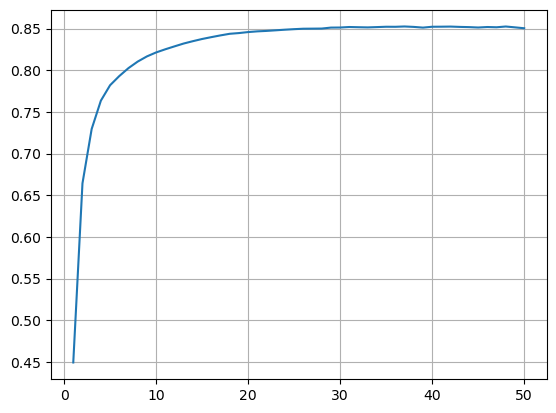

In [202]:
plt.plot(NHHI_series.mean(axis=0))
plt.grid()

In [203]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [212]:
NHHI_series_arr = NHHI_series.drop(columns=np.arange(31,51)).dropna().to_numpy()

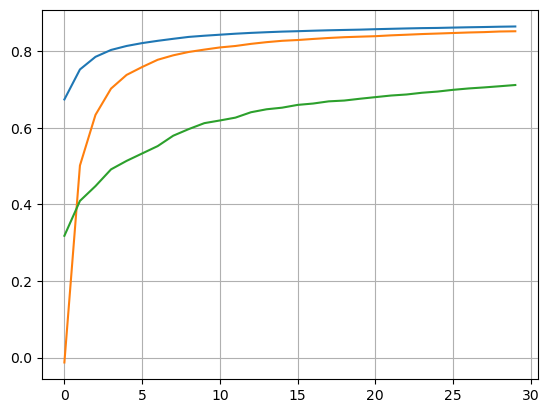

In [218]:
kmeans = KMeans(n_clusters=3, n_init=10).fit(NHHI_series_arr)
plt.plot(kmeans.cluster_centers_.T)
plt.grid()

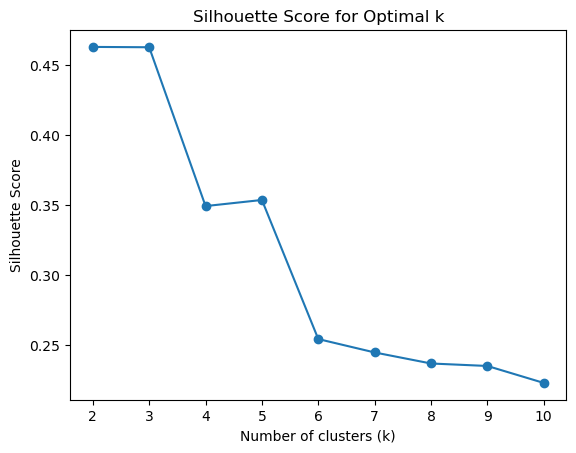

In [214]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(NHHI_series_arr)
    silhouette_scores.append(silhouette_score(NHHI_series_arr, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

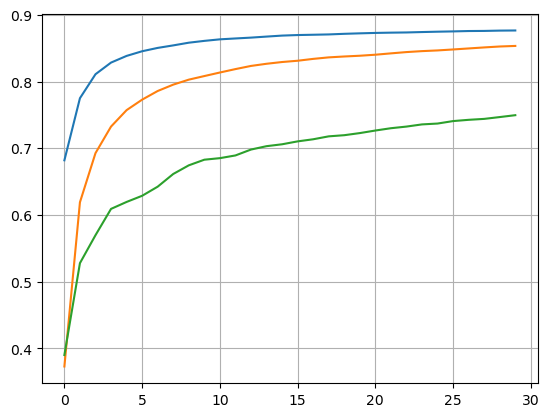

In [226]:
kmeans = GaussianMixture(n_components=3, n_init=20).fit(NHHI_series_arr)
plt.plot(kmeans.means_.T)
plt.grid()

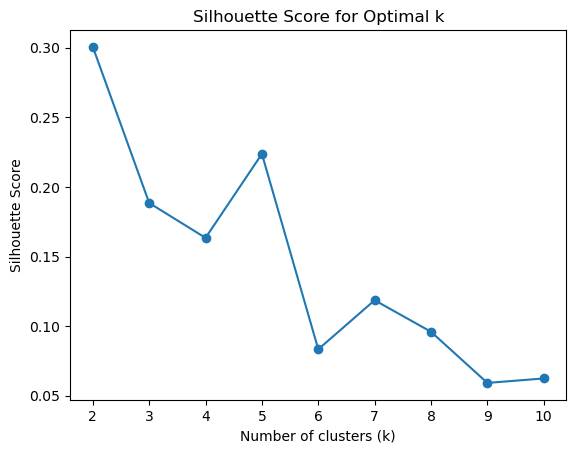

In [223]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, n_init=20)
    labels = kmeans.fit_predict(NHHI_series_arr)
    silhouette_scores.append(silhouette_score(NHHI_series_arr, labels))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

Explained Variance (Eigenvector 1): 0.61
Explained Variance (Eigenvector 2): 0.25
Explained Variance (Eigenvector 3): 0.07
Explained Variance (Eigenvector 4): 0.03
Explained Variance (Eigenvector 5): 0.01


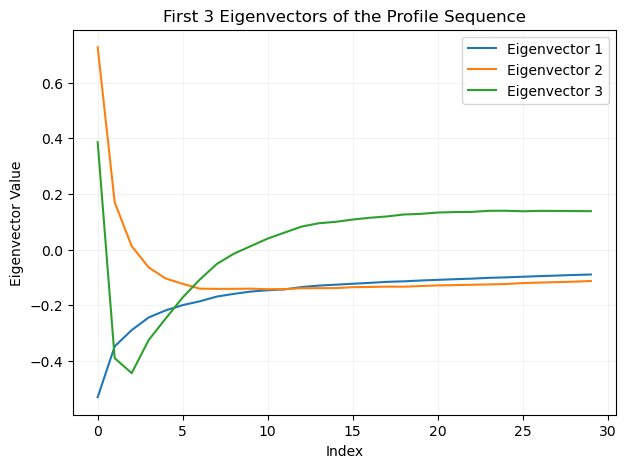

In [227]:
from sklearn.decomposition import PCA

# Perform PCA on profile sequence
pca = PCA()
pca.fit(NHHI_series_arr)

# Get the principal components
principal_components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for the first 5 principal components
for i in range(5):
    print(f"Explained Variance (Eigenvector {i+1}): {explained_variance_ratio[i]:.2f}")

# Plot the first 3 eigenvectors of the profile sequence
plt.figure(figsize=(7, 5))

for i in range(3):
    plt.plot(principal_components[i], label=f'Eigenvector {i+1}')

plt.xlabel('Index')
plt.ylabel('Eigenvector Value')
plt.title('First 3 Eigenvectors of the Profile Sequence')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

In [228]:
principal_components[0].T@principal_components[1]

5.085203557263591e-16